# Предсказание оттока пользователей (осень 2022)

### Sofya Lyakhova (kaggle user name - sofya22)

## Исследование
### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
data = pd.read_csv('../input/advanced-dls-spring-2021/train.csv')
test_data = pd.read_csv('../input/advanced-dls-spring-2021/test.csv')

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [3]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


В данных нет null значений

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

   Но можно заметить что тип признака TotalSpent - object, но это числовой признак. Было найдено 9 пустых значений, признак переведен в числовой вид и заполнены значения nan.

In [5]:
(data.TotalSpent == ' ').sum()

9

In [6]:
data.TotalSpent = pd.to_numeric(data.TotalSpent, errors='coerce')
test_data.TotalSpent = pd.to_numeric(test_data.TotalSpent, errors='coerce')
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Возможно, это новые клиенты, которые еще не сделали первый платеж => нужно заполнить значением 0.

In [7]:
data["TotalSpent"] = data.TotalSpent.fillna(0).astype(float)
test_data["TotalSpent"] = test_data.TotalSpent.fillna(0).astype(float)
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

## Анализ данных

Гистограмма числовых признаков

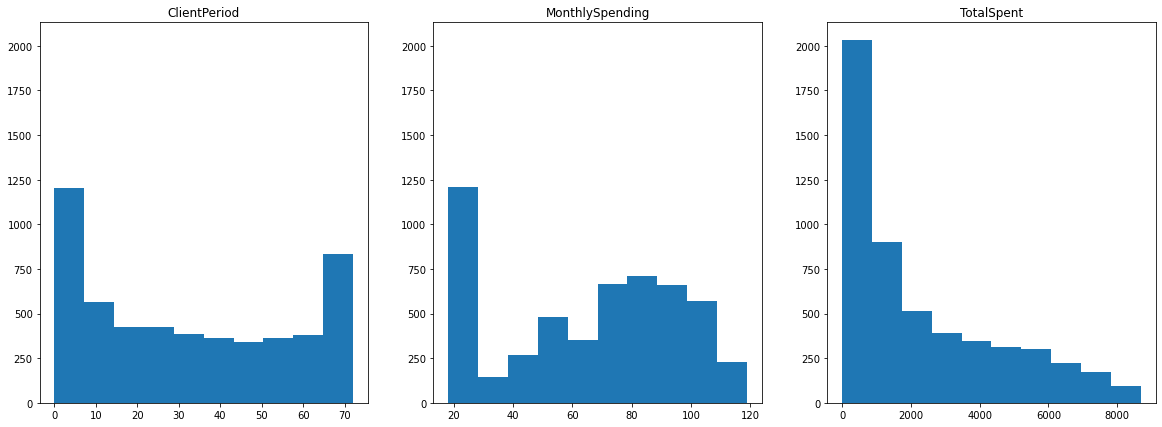

In [8]:
plt.figure(figsize=(20, 7))
ax = None
for i, column in enumerate(num_cols):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    ax.set_title(column)
    plt.hist(data[column])
plt.show()

Гистограмма категориальных признаков

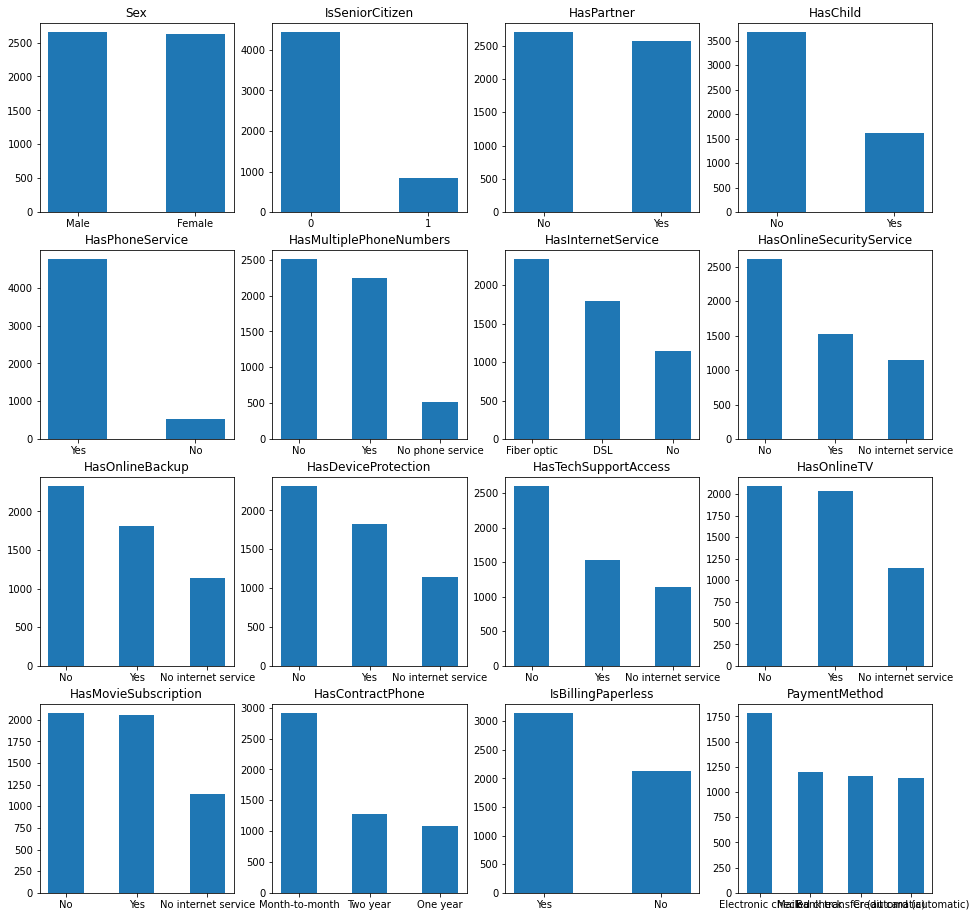

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
ax = ax.ravel()
for i, column in enumerate(cat_cols):
    serie = data[column].value_counts()
    labels = list(serie.index)
    values = list(serie)
    x = np.arange(len(labels))
    ax[i].set_title(column)
    ax[i].bar(x, values, width=0.5)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)

Круговые диаграммы

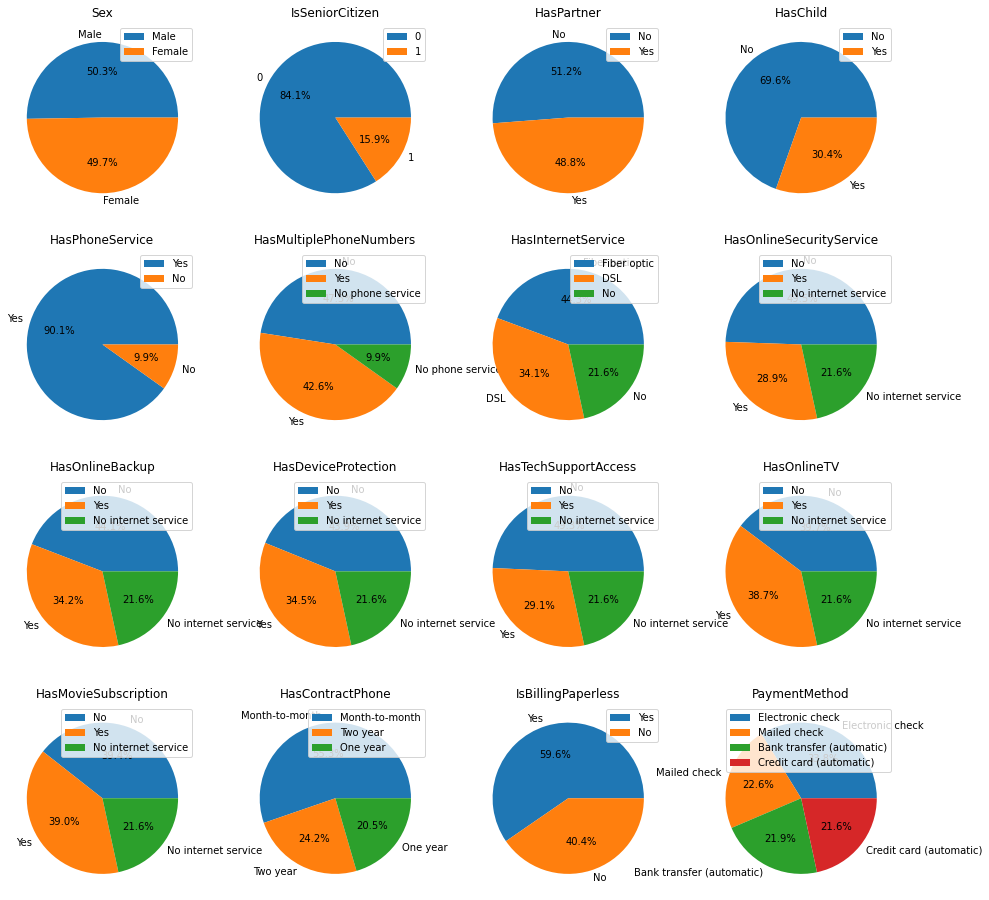

In [10]:
fig = plt.figure(figsize=(16, 16))
for i in range(len(cat_cols)):
    data_i = data[cat_cols[i]].value_counts()
    plt.subplot(4, 4, i+1)
    plt.pie(data_i, labels = data_i.index, autopct='%1.1f%%')
    plt.title(cat_cols[i])
    plt.legend()

Распределение целевой переменной

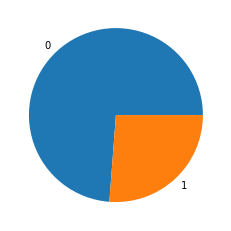

In [11]:
targets = data[target_col].value_counts()
plt.pie(
    targets,
    labels=list(targets.index)
)
plt.show()

Класс 1 представлен четвертью данных (люди чаще остаются, чем уходят). Данные классы не являются несбалансированными

## Применение линейных моделей

In [12]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

In [13]:
data_origin = data[feature_cols]
y_train = data[target_col]
X_train = data.drop(target_col, axis=1)

Обработка данных - one-hot-encoding для категориальных признаков и нормирование числовых признаков

In [14]:
prep_pipeline = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(sparse=False), cat_cols)])

In [15]:
cls = make_pipeline(
    prep_pipeline,
    LogisticRegression(random_state=42, solver="saga", max_iter=10000))

Гиперпараметры передаем в GridSearchCV

In [16]:
param_grid = {
    'logisticregression__penalty' : ['l1', 'l2', 'elasticnet', None],
    'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'logisticregression__class_weight': ['balanced', None]}

grid_cv = GridSearchCV(cls, param_grid, cv=5, verbose=0, scoring='roc_auc', refit=True)

Обучение модели

In [17]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                

Лучшая модель и ее паремтры

In [18]:
print("Best ROC-AUC metric:", round(grid_cv.best_score_,4))
grid_cv.best_estimator_[1]

Best ROC-AUC metric: 0.8451


LogisticRegression(C=100, max_iter=10000, penalty='l1', random_state=42,
                   solver='saga')

## Применение градиентного бустинга

In [19]:
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, roc_curve

Тренировочная и тестовая выборки

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[target_col], test_size=0.2, random_state=42)

In [21]:
X_train

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
4556,31,73.55,2094.65,Female,1,No,No,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)
1468,59,100.05,6034.85,Female,0,Yes,No,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Mailed check
3142,60,99.00,6017.90,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Electronic check
2093,6,73.85,401.30,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check
1505,72,24.75,1859.10,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,14,91.65,1301.00,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Electronic check
3772,19,73.20,1441.10,Female,0,Yes,No,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
5191,50,20.55,1070.25,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
5226,8,84.50,662.65,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Bank transfer (automatic)


Пробуем CatBoost с параметрами по умолчанию:

Learning rate set to 0.019062
0:	learn: 0.6798227	total: 74.7ms	remaining: 1m 14s
1:	learn: 0.6678084	total: 88.3ms	remaining: 44s
2:	learn: 0.6553003	total: 100ms	remaining: 33.2s
3:	learn: 0.6435910	total: 111ms	remaining: 27.7s
4:	learn: 0.6326850	total: 123ms	remaining: 24.4s
5:	learn: 0.6225823	total: 134ms	remaining: 22.3s
6:	learn: 0.6128742	total: 144ms	remaining: 20.4s
7:	learn: 0.6048572	total: 149ms	remaining: 18.5s
8:	learn: 0.5958847	total: 160ms	remaining: 17.6s
9:	learn: 0.5871696	total: 172ms	remaining: 17s
10:	learn: 0.5792007	total: 182ms	remaining: 16.4s
11:	learn: 0.5713099	total: 195ms	remaining: 16s
12:	learn: 0.5643834	total: 205ms	remaining: 15.6s
13:	learn: 0.5569418	total: 217ms	remaining: 15.3s
14:	learn: 0.5502712	total: 229ms	remaining: 15s
15:	learn: 0.5441586	total: 240ms	remaining: 14.8s
16:	learn: 0.5381109	total: 251ms	remaining: 14.5s
17:	learn: 0.5324322	total: 263ms	remaining: 14.4s
18:	learn: 0.5268003	total: 275ms	remaining: 14.2s
19:	learn: 0.521

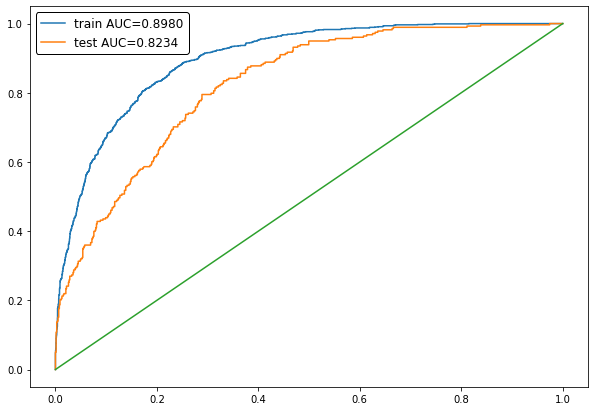

In [22]:
clf = catboost.CatBoostClassifier()
clf.fit(X_train, y_train, cat_features=cat_cols)

y_train_predicted = clf.predict_proba(X_train)[:, 1]
y_test_predicted = clf.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Протестируйте разные занчения параметра количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию (iterations и learning_rate)

In [23]:
cat_class_1 = CatBoostClassifier(logging_level='Silent')

parameters = {
'depth': [4, 5, 6],
'iterations': [100, 200, 300, 400, 500, 600, 700]
}

grid_search_cv = GridSearchCV(cat_class_1, param_grid=parameters)
grid_search_cv.fit(X_train, y_train, cat_features=cat_cols)

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fe0f44bf310>,
             param_grid={'depth': [4, 5, 6],
                         'iterations': [100, 200, 300, 400, 500, 600, 700]})

In [24]:
# grid_search_cv.fit(X_train, y_train, cat_features=cat_cols)
y_train_pred = grid_search_cv.predict_proba(X_train)[:, 1]
y_test_pred = grid_search_cv.predict_proba(X_test)[:, 1]

print(f'Лучшее качество на train: {roc_auc_score(y_train, y_train_pred)} \nЛучшее качество на test: {roc_auc_score(y_test, y_test_pred)}')
print(f'Параметры: {grid_search_cv.best_params_}')

Лучшее качество на train: 0.8768772390186265 
Лучшее качество на test: 0.8294853206010286
Параметры: {'depth': 4, 'iterations': 600}


По итогам тестов лучшие параметры

In [25]:
#best_model = CatBoostClassifier(iterations=700, depth=3, logging_level='Silent')
best_model = CatBoostClassifier(depth=4, iterations=250, learning_rate=0.05, min_data_in_leaf=100, logging_level='Silent')

best_model.fit(X_train, y_train, cat_features=cat_cols)

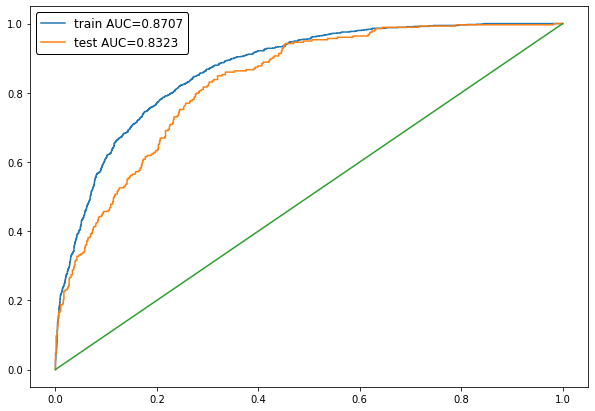

In [26]:
y_train_predicted = best_model.predict_proba(X_train)[:, 1]
y_test_predicted = best_model.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

## Предсказания

In [27]:
X_test = pd.read_csv('../input/advanced-dls-spring-2021/test.csv')
X_test['TotalSpent'] = pd.to_numeric(X_test['TotalSpent'], errors='coerce')
X_test["TotalSpent"] = data.TotalSpent.fillna(0).astype(float)

In [28]:
submission = pd.read_csv('../input/advanced-dls-spring-2021/submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv', index=False)

In [29]:
submission

,Id,Churn
0,0,0.040885
1,1,0.736186
2,2,0.819283
3,3,0.020318
4,4,0.003620
...,...,...
1756,1756,0.089874
1757,1757,0.008147
1758,1758,0.788045
1759,1759,0.628516


Score 0.8323